# <center>XGBoost : 可伸缩且灵活的梯度提升<center/>

<center>**Date : 20180907**</center>
<center>**Author : TianSong**</center>

##  1、灵活：支持回归, 分类, 排序和用户定义的目标函数.

## 2、多语言：C++、Python、R、Java、Scala、Julia

## 3、可移植、分布式、性能好、实践应用多

### Boosted Trees 介绍
XGBoost 是 “Extreme Gradient Boosting” 的缩写，其中 “Gradient Boosting” 一词在论文 Greedy Function Approximation: A Gradient Boosting Machine 中，由 Friedman 提出。 XGBoost 基于这个原始模型。 这是 gradient boosted trees（梯度增强树）的教程，大部分内容是基于 xgboost 的作者的这些 slides 。

GBM （boosted trees，增强树）已经有一段时间了，关于这个话题有很多的材料。 这个教程试图用监督学习的元素以独立和有原则的方式解释 boosted trees （增强树）。 我们认为这个解释更加清晰，更加正式，并激发了 xgboost 中使用的变体。

#### 监督学习的要素
XGBoost 用于监督学习问题，我们使用训练数据 $x_i$ 来预测目标变量 $y_i$ 。 在我们深入了解 boosted trees 之前，首先回顾一下监督学习的重要组成部件。

#### 模型和参数
监督学习中的 model（模型） 通常是指给定输入 $x_i$ 如何去预测输出 $y_i$ 的数学结构。 例如，一个常见的模型是一个 linear model（线性模型）（如线性回归和 logistic regression），其中的预测是由 $y^i=∑_{j}w_{j}x_{ij}$ 给出的，这是加权输入特征的线性组合（线性叠加的方式）。 其实这里的预测 y 可以有不同的解释，取决于做的任务。 例如，我们可以通过 logistic 转换得到 logistic regression 中 positive 类别的概率，当我们想要对输出结果排序的时候，也可以作为排序得分指标等。

parameters（参数） 是我们需要从数据中学习的未确定部分。在线性回归问题中，参数是系数$w$。 通常我们使用$Θ$来表示参数。

#### 目标函数：训练损失 + 正则
基于对 $y_i$ 的不同理解，我们可以得到不同的问题，比如回归，分类，排序等。 我们需要找到一种方法来找到训练数据的最佳参数。为了做到这一点，我们需要定义一个所谓的 objective function（目标函数） 以给定一组参数来衡量模型的性能。

关于目标函数的一个非常重要的事实是，它们 must always（必须总是） 包含两个部分：training loss （训练损失） 和 regularization（正则化）。

<center>$$Obj(\Theta) = L(\Theta) + \Omega(\Theta)$$</center>
<br>
其中 L 是训练损失函数，$Ω$ 是正则化项。 training loss （训练损失）衡量我们的数据对训练数据的预测性。 例如，常用的训练损失是 mean squared error（均方误差，MSE）。

<center>$$L(\Theta) = \sum_i (y_i-\hat{y}_i)^2$$</center>
<br>
另一个常用的损失函数是 logistic 回归的 logistic 损失。

<center>$$L(\theta) = \sum_i[ y_i\ln (1+e^{-\hat{y}_i}) + (1-y_i)\ln (1+e^{\hat{y}_i})]$$</center>
<br>
regularization term（正则化项） 是人们通常忘记添加的内容。正则化项控制模型的复杂性，这有助于避免过拟合。 这听起来有些抽象，那么我们在下面的图片中考虑下面的问题。在图像左上角给出输入数据点的情况下，要求您在视觉上 fit（拟合） 一个 step function（阶梯函数）。 您认为三种中的哪一种解决方案是最拟合效果最好的？

![](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/step_fit.png)
<br/>
<br/>

答案已经标注为红色了。请思考一下这个是否在你的视觉上较为合理？总的原则是我们想要一个 simple（简单） 和 predictive（可预测） 的模型。 两者之间的权衡也被称为机器学习中的 bias-variance tradeoff（偏差-方差 权衡）。

对于线性模型常见的正则化项有 L2 正则和 L1 正则。这样的目标函数的设计来自于统计学习中的一个重要概念，也是我们刚才说的， bias-variance tradeoff（偏差-方差 权衡）。比较感性的理解， Bias 可以理解为假设我们有无限多数据的时候，可以训练出最好的模型所拿到的误差。而 Variance 是因为我们只有有限数据，其中随机性带来的误差。目标中误差函数鼓励我们的模型尽可能去拟合训练数据，这样相对来说最后的模型会有比较小的 bias 。而正则化项则鼓励更加简单的模型。因为当模型简单之后，有限数据拟合出来结果的随机性比较小，不容易过拟合，使得最后模型的预测更加稳定。

### 为什么要介绍 general principle（一般原则）
上面介绍的要素构成了监督学习的基本要素，它们自然是机器学习工具包的基石。 例如，你应该能够描述 boosted trees 和 random forests 之间的差异和共同点。 以正式的方式理解这个过程也有助于我们理解我们正在学习的目标以及启发式算法背后的原因，例如 pruning 和 smoothing 。

### tree ensembles（树集成）
既然我们已经介绍了监督学习的内容，那么接下来让我们开始介绍真正的 trees 吧。 首先，让我们先来了解一下 xgboost 的 model（模型） ： tree ensembles（树集成）。 树集成模型是一组 classification and regression trees （CART）。 下面是一个 CART 的简单的示例，它可以分类是否有人喜欢电脑游戏

![](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/cart.png)

我们把一个家庭的成员分成不同的叶子，并把他们分配到相应的叶子节点上。 CART 与 decision trees（决策树）有些许的不同，就是叶子只包含决策值。在 CART 中，每个叶子都有一个 real score （真实的分数），这给了我们更丰富的解释，超越了分类。 这也使得统一的优化步骤更容易，我们将在本教程的后面部分看到。

通常情况下，单棵树由于过于简单而不够强大到可以支持在实践中使用的。实际使用的是所谓的 tree ensemble model（树集成模型），它将多棵树的预测加到一起。

![](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png)

上图是两棵树的集成的例子。将每棵树的预测分数加起来得到最终分数。 如果你看一下这个例子，一个重要的事实就是两棵树互相 complement（补充） 。 在数学表示上，我们可以在表单中编写我们的模型。

<center>$$\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$$</center>

其中 K 是树的数量， f 是函数空间 F 的函数， F 是所有可能的 CARTs 的集合。所以我们优化的目标可以写成

<center>$$obj(\Theta) = \sum_i^n l(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k)$$</center>

那么问题来了，random forests（随机森林）的 model（模型） 是什么？这正是 tree ensembles（树集成）！所以 random forests 和 boosted trees 在模型上并没有什么不同，不同之处在于我们如何训练它们。这意味着如果你写一个 tree ensembles（树集成）的预测服务，你只需要编写它们中的一个，它们应该直接为 random forests（随机森林）和 boosted trees（增强树）工作。这也是监督学习基石元素的一个例子。

### Tree Boosting
在介绍完模型之后，我们从真正的训练部分开始。我们应该怎么学习 trees 呢？ 答案是，对于所有的监督学习模型都一样的处理：定义一个合理的目标函数，然后去尝试优化它！

假设我们有以下目标函数（记住它总是需要包含训练损失和正则化）

<center>$\begin{split}Obj = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i) \\
\end{split}$

### 附加训练
我们想要问的第一件事就是树的 parameters（参数） 是什么。 你可能已经发现了，我们要学习的是那些函数 fi ，每个函数都包含树的结构和叶子分数。这比传统的你可以找到捷径的优化问题要难得多。在 tree ensemble 中，参数对应了树的结构，以及每个叶子节点上面的预测分数。 一次性训练所有的树并不容易。 相反，我们使用一个附加的策略：优化好我们已经学习完成的树，然后一次添加一棵新的树。 我们通过 y^(t)i 来关注步骤 t 的预测值，所以我们有

<center>$\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)
\end{split}$

另外还有一个问题，每一步我们想要哪棵 tree 呢？一个自然而然的事情就是添加一个优化我们目标的方法。

<center>$\begin{split}Obj^{(t)} & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t) + constant
\end{split}$

如果我们考虑使用 MSE 作为我们的损失函数，它将是下面的形式。

<center>$\begin{split}Obj^{(t)} & = \sum_{i=1}^n (y_i - (\hat{y}_i^{(t-1)} + f_t(x_i)))^2 + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n [2(\hat{y}_i^{(t-1)} - y_i)f_t(x_i) + f_t(x_i)^2] + \Omega(f_t) + constant
\end{split}$

MSE 的形式比较友好，具有一阶项（通常称为残差）和二次项。 对于其他形式的损失（例如，logistic loss），获得这么好的形式并不是那么容易。 所以在一般情况下，我们把损失函数的泰勒展开到二阶

<center>$$Obj^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + constant$$

其中$g_i$和$h_i$被定义为

<center>$\begin{split}g_i &= \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)})\\
h_i &= \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)})
\end{split}$

我们删除了所有的常量之后， t 步骤中的具体目标就变成了

<center>$$\sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t)$$

这成为了新树的优化目标。这个定义的一个重要优点是它只依赖于$g_i$和$h_i$。这就是 xgboost 如何支持自定义损失函数。 我们可以使用完全相同的使用$g_i$和$h_i$作为输入的 solver（求解器）来对每个损失函数进行优化，包括 logistic regression， weighted logistic regression。

### 模型复杂度
我们已经介绍了训练步骤，但是等等，还有一个重要的事情，那就是 regularization（正则化） ！ 我们需要定义树的复杂度$Ω(f)$。为了做到这一点，让我们首先改进一棵树的定义$f(x)$如下

<center>$f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\} .$

这里 w 是树叶上的分数向量，q 是将每个数据点分配给叶子的函数，T 是树叶的数量。 在 XGBoost 中，我们将复杂度定义为

<center>$$\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2$$

当然有不止一种方法来定义复杂度，但是这个具体的方法在实践中运行良好。正则化是大多数树的包不那么谨慎或简单忽略的一部分。这是因为对传统的树学习算法的对待只强调提高 impurity（不纯性），而复杂度控制则是启发式的。 通过正式定义，我们可以更好地了解我们正在学习什么，是的，它在实践中运行良好。

### The Structure Score（结构分数）
这是 derivation（派生）的神奇部分。在对树模型进行重新格式化之后，我们可以用第 t 棵树来编写目标值如 :

<center>$$\begin{split}Obj^{(t)} &\approx \sum_{i=1}^n [g_i w_{q(x_i)} + \frac{1}{2} h_i w_{q(x_i)}^2] + \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2\\
&= \sum^T_{j=1} [(\sum_{i\in I_j} g_i) w_j + \frac{1}{2} (\sum_{i\in I_j} h_i + \lambda) w_j^2 ] + \gamma T
\end{split}$$

其中$I_j=\{i|q(x_i)=j\}$是分配给第$j$个叶子的数据点的索引的集合。 请注意，在第二行中，我们更改了总和的索引，因为同一叶上的所有数据点都得到了相同的分数。 我们可以通过定义$G_j=∑_{i∈I_j}g_i$和$H_j=∑_{i∈I_j}h_i$ 来进一步压缩表达式 :

<center>$$Obj^{(t)} = \sum^T_{j=1} [G_jw_j + \frac{1}{2} (H_j+\lambda) w_j^2] +\gamma T$$

在这个等式中 $w_j$ 是相互独立的，形式$ G_jw_j+12(H_j+λ)w^2_j$ 是二次的，对于给定的结构 $q(x)$ 的最好的 $w_j$，我们可以得到最好的客观规约:

<center>$$\begin{split}w_j^\ast = -\frac{G_j}{H_j+\lambda}\\
Obj^\ast = -\frac{1}{2} \sum_{j=1}^T \frac{G_j^2}{H_j+\lambda} + \gamma T
\end{split}$$

最后一个方程度量一个树结构$q(x)$**how good（到底有多好）**。

![](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/struct_score.png)

如果这一切听起来有些复杂，我们来看一下图片，看看分数是如何计算的。 基本上，对于一个给定的树结构，我们把统计 $g_i$ 和 $h_i$ push 到它们所属的叶子上，统计数据加和到一起，然后使用公式计算树是多好。 除了考虑到模型的复杂度，这个分数就像决策树中的杂质测量一样（例如，熵/GINI系数）。

### 学习树结构
既然我们有了一个方法来衡量一棵树有多好，理想情况下我们会列举所有可能的树并挑选出最好的树。 在实践中，这种方法是比较棘手的，所以我们会尽量一次优化树的一个层次。 具体来说，我们试图将一片叶子分成两片，并得到分数

<center>$$Gain = \frac{1}{2} \left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right] - \gamma$$

这个公式可以分解为 1) 新左叶上的得分 2) 新右叶上的得分 3) 原始叶子上的得分 4) additional leaf（附加叶子）上的正则化。 我们可以在这里看到一个重要的事实：如果增益小于$γ$，我们最好不要添加那个分支。这正是基于树模型的 pruning（剪枝） 技术！通过使用监督学习的原则，我们自然会想出这些技术工作的原因 :)

对于真实有价值的数据，我们通常要寻找一个最佳的分割。为了有效地做到这一点，我们把所有的实例按照排序顺序排列，如下图所示。

![](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/split_find.png)

然后从左到右的扫描就足以计算所有可能的拆分解决方案的结构得分，我们可以有效地找到最佳的拆分.

### **Python代码XGBoost莺尾花数据实例**

In [9]:
from sklearn.datasets import load_iris
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [10]:
# read in the iris data
iris = load_iris()

X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234565)

In [11]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax', # 多分类的问题
    'num_class': 3,               # 多分类的问题
    'gamma': 0.1,                 # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 6,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,             # 随机采样训练样本
    'colsample_bytree': 0.7,      # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 1,                  # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.1,                   # 如同学习率
    'seed': 1000,                 # 随机种子数
    'nthread': 4,                 # cpu 线程数
}

plst = params.items()

In [12]:
dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 500
model = xgb.train(plst, dtrain, num_rounds)

In [13]:
# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
ans = model.predict(dtest)

# 计算准确率
cnt1 = 0
cnt2 = 0
for i in range(len(y_test)):
    if ans[i] == y_test[i]:
        cnt1 += 1
    else:
        cnt2 += 1

print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))

Accuracy: 96.67 % 


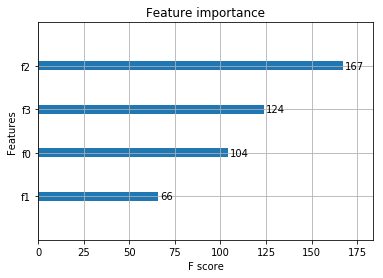

In [14]:
# 显示重要特征
plot_importance(model)
plt.show()